In [1]:
import random
import torch
import pandas as pd
import numpy as np
import json
from torch import nn
from torch.optim import AdamW, Adam
from transformers import AutoModel, AutoTokenizer, AutoModelForTokenClassification
from transformers import get_scheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import metrics as metrics
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import re
from nltk.tokenize import sent_tokenize

random.seed(42)
reprocess_raw =  True

batch_size = 8 # documents
learning_rate = 5e-5
n_epochs = 10

task_map = {'Quantity':1}
# task_map = {'Quantity':1,'MeasuredProperty':2,'MeasuredEntity':3,'Qualifier':4} # uncomment for multi-class
num_classes = len(task_map)

# model_name = 'allenai/biomed_roberta_base'
model_name = 'bert-base-cased'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = 'cpu' # uncomment this to make debugging easier

data_size_reduce = 1 # multiplier for making small datasets



In [2]:
currentdir = os.getcwd() # ~/MeasEval/baselines

combopath_txt = os.path.join(currentdir, "../data/raw/combo/text/")
combopath_annot = os.path.join(currentdir, "../data/raw/combo/tsv/")

interimpath = os.path.join(currentdir, "../data/interim/")

In [3]:
def process_raw_txt(docs):
    processesd_txt = {}
    remove_markers = True

    cnt_toks = {"figs.": 0, "fig.": 0, "et al.": 0,
            "ref.": 0, "eq.": 0, "e.g.": 0,
            "i.e.": 0, "nos.": 0, "no.": 0,
            "spp.": 0
            }
    regex_end_checker = [".*[a-zA-Z]figs\.$", 
                        ".*[a-zA-Z]fig\.$",
                        ".*[a-zA-Z]et al\.$",
                        ".*[a-zA-Z]ref\.$",
                        ".*[a-zA-Z]eq\.$",
                        ".*[a-zA-Z]e\.g\.$",
                        ".*[a-zA-Z]i\.e\.$",
                        ".*[a-zA-Z]nos\.$",
                        ".*[a-zA-Z]no\.$",
                        ".*[a-zA-Z]spp\.$",
                        # figs., fig., et al., Ref., Eq., e.g., i.e., Nos., No., spp.
                    ]

    assert len(cnt_toks) == len(regex_end_checker)

    for docId, doc in docs.items():
        flag = False
        sentences = sent_tokenize(doc)

        fixed_sentence_tokens = []
        curr_len = 0
        for s in sentences:
            if flag == True:
                assert s[0] != ' '
                white_length = doc[curr_len:].find(s[0])

                prev_len = len(fixed_sentence_tokens[-1])
                fixed_sentence_tokens[-1] = fixed_sentence_tokens[-1] + (" "*white_length) + s

                assert fixed_sentence_tokens[-1][prev_len+white_length] == doc[curr_len+white_length], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                tmp_this_sent_len = white_length + len(s)
                assert fixed_sentence_tokens[-1][-1] == doc[curr_len+tmp_this_sent_len-1], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                curr_len += tmp_this_sent_len
            else:
                if len(fixed_sentence_tokens) != 0:
                    assert s[0] != ' '
                    white_length = doc[curr_len:].find(s[0])
                    fixed_sentence_tokens.append( (" "*white_length) + s )
                else:
                    fixed_sentence_tokens.append(s)
                assert fixed_sentence_tokens[-1][0] == doc[curr_len], (fixed_sentence_tokens, doc, curr_len, tmp_this_sent_len)
                tmp_this_sent_len = len(fixed_sentence_tokens[-1])
                assert fixed_sentence_tokens[-1][-1] == doc[curr_len+tmp_this_sent_len-1], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                curr_len += tmp_this_sent_len

            lower_cased_s = fixed_sentence_tokens[-1].lower()
            flag = False
            if remove_markers:
                for i, k in enumerate(cnt_toks):
                    this_regex_pattern = regex_end_checker[i]
                    if lower_cased_s.endswith(k) and re.match(this_regex_pattern, lower_cased_s) == None:
                        cnt_toks[k] += 1
                        flag = True
                        break

        processesd_txt[docId] = ''.join(fixed_sentence_tokens)
    return processesd_txt


In [4]:
def read_data(reprocess_raw = False):

    if reprocess_raw == True:
        docIds = []
        combo_txt = {}
        for fn in os.listdir(combopath_txt):
            docIds.append(fn[:-4])
            path = combopath_txt+fn
            with open(path) as textfile:
                    text = textfile.read()
                    #[:-4] strips off the .txt to get the id
                    combo_txt[fn[:-4]] = text

        combo_annot = pd.DataFrame()
        for fn in os.listdir(combopath_annot):
            path = combopath_annot+fn
            file = pd.read_csv(path,delimiter='\t',encoding='utf-8')
            combo_annot = pd.concat([combo_annot, file],ignore_index=True)

        combo_txt = process_raw_txt(combo_txt)
        assert docIds == list(combo_txt.keys()), (len(docIds), len(list(combo_txt.keys())))

        with open(interimpath+'combo_txt.json','w') as f:
            json.dump(combo_txt, f)

        combo_annot.to_csv(interimpath+'combo_annot.csv')

        return docIds, combo_txt, combo_annot
    else:
        combo_annot = pd.read_csv(interimpath+'combo_annot.csv')

        with open(interimpath+'combo_txt.json','r') as f:
            combo_txt = json.load(f)

        docIds = list(combo_txt.keys())
    
        return docIds, combo_txt, combo_annot

In [5]:
combo_docs, combo_txt, combo_annot = read_data(reprocess_raw = reprocess_raw)

In [6]:
#### train/dev/test split options

random.seed(42)

percent_to_test = .1
percent_to_dev = .2
percent_to_train =  1 - percent_to_dev - percent_to_test

n_doc = len(combo_docs)
split_train = int(np.round(n_doc * percent_to_train))
split_dev = split_train + int(np.round(n_doc * percent_to_dev))

train_docs = combo_docs[:split_train]
dev_docs = combo_docs[split_train:split_dev]
test_docs = combo_docs[split_dev:]

train_docs = random.sample(train_docs, int(len(train_docs)*data_size_reduce))
dev_docs = random.sample(dev_docs, int(len(dev_docs)*data_size_reduce))
test_docs = random.sample(test_docs, int(len(test_docs)*data_size_reduce))

In [7]:
########## Tokenizer ###########

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
def process_annotation_set(annot_set):

    annot_set_processed = []

    annot_set['comboIds'] = annot_set[['docId','annotId']].agg('_'.join, axis=1)
    annot_set.set_index('comboIds',inplace=True)

    for comboId in list(annot_set.index):
        
        docId = annot_set.loc[comboId]['docId']
        annotId = annot_set.loc[comboId]['annotId']

        annotType = annot_set.loc[comboId]['annotType']
        annotSpan = [annot_set.loc[comboId]['startOffset'],annot_set.loc[comboId]['endOffset']]

        ent_annot_processed = {
            'comboId':comboId,
            'docId':docId,
            'annotId':annotId,
            'annotType':annotType,
            'annotSpan':annotSpan,
            'subSpanType':np.nan,
            'linkId':np.nan,
            'linkSpan':np.nan,
            'subSpan':np.nan,
            'unit':np.nan,
            'unitEncoded':np.nan,
            'misc':np.nan
        }
        
        other = annot_set.loc[comboId]['other']
        if isinstance(other,str):
            otherDict = json.loads(str(other))

            if annot_set.loc[comboId]['annotType'] != 'Quantity':

                ent_annot_processed['subSpanType'] = list(otherDict.keys())[0]
                link = list(otherDict.values())[0]

                ent_annot_processed['linkId'] = link
                linkIdx = docId+'_'+link
                linkSpan = [int(annot_set.loc[linkIdx]['startOffset']),int(annot_set.loc[linkIdx]['endOffset'])]
                ent_annot_processed['linkSpan'] = linkSpan

                spanEnds = annotSpan + linkSpan
                ent_annot_processed['subSpan'] = [max(spanEnds),max(spanEnds)]

            elif 'unit' in list(otherDict.keys()):
                unit = otherDict['unit']
                ent_annot_processed['unit'] = unit
                ent_annot_processed['unitEncoded'] = tokenizer.encode(unit)[1:-1]
            else:
                ent_annot_processed['misc'] = otherDict


        annot_set_processed.append(ent_annot_processed)
   
    return pd.DataFrame.from_dict(annot_set_processed).set_index('comboId')

combo_annot_processed = process_annotation_set(combo_annot)
combo_annot_processed.to_csv(interimpath+'combo_annot_processed.csv')
combo_annot_processed.sample(7)


,docId,annotId,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,
S0378112713005288-1720_T3-2,S0378112713005288-1720,T3-2,MeasuredProperty,"[351, 360]",HasQuantity,T1-2,"[374, 388]","[388, 388]",NaN,NaN,NaN
S2213671113000738-787_T1-1,S2213671113000738-787,T1-1,Quantity,"[60, 65]",NaN,NaN,NaN,NaN,μm,"[429, 1306]",NaN
S0016236113008041-3269_T88-8,S0016236113008041-3269,T88-8,Quantity,"[829, 843]",NaN,NaN,NaN,NaN,ppm,"[4329, 1306]",NaN
S0032063312003054-2458_T2-2,S0032063312003054-2458,T2-2,MeasuredProperty,"[223, 294]",HasQuantity,T1-2,"[303, 307]","[307, 307]",NaN,NaN,NaN
S0167739X12001525-6016_T1-4,S0167739X12001525-6016,T1-4,Quantity,"[506, 514]",NaN,NaN,NaN,NaN,%,[110],NaN
S0012821X13002185-1217_T71-1,S0012821X13002185-1217,T71-1,MeasuredProperty,"[129, 133]",HasQuantity,T61-1,"[123, 128]","[133, 133]",NaN,NaN,NaN
S0022000014000026-12523_T1-1,S0022000014000026-12523,T1-1,Quantity,"[1231, 1232]",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
### insert special tokens for subspans (Sam)
# will make docs longer

# def char_map(doc_annot, task_map)


def tokenize_and_align_labels(
                                doc_list=combo_docs,
                                txt=combo_txt,
                                processed_annotation=combo_annot_processed,
                                tokenizer=tokenizer,
                                taskLabelMap=task_map
                            ):

    toks_with_labels = []
    special_ids = tokenizer.all_special_ids

    for doc in doc_list:
        # print(doc)
        # print(processed_annotation.loc[processed_annotation['docId'] == doc])
        doc_annot = processed_annotation.loc[processed_annotation['docId'] == doc]
        doc_annot.set_index('annotId',inplace=True)
        # print(doc_annot)

        encoded_txt = tokenizer(txt[doc], padding='max_length', max_length=512, truncation=True)
        encoded_tokens = encoded_txt['input_ids']
        # print(encoded_tokens)

        ############### Label Primary Spans ###############

        labelIds = np.full(len(encoded_tokens),-1)
        taskCharMap = {} # 
        taskCharList = []
        taskAnnotIdCharMap = {} # to check for token collision
        
        for task in list(taskLabelMap.keys()):
            #print(task)
            annotId = doc_annot.loc[doc_annot['annotType']==task].index
            # print(annotId)
            spans = list(doc_annot.loc[doc_annot['annotType']==task]['annotSpan'])
            # print(spans)
            for span in spans:
                # print(span)
                span = list(range(span[0],span[-1]))
                # print(span)
                for spanCharIdx in span:
                    # print(spanCharIdx)
                    taskCharMap[spanCharIdx] = taskLabelMap[task]
                # print(taskCharMap)
                    # taskAnnotIdCharMap[spanCharIdx] = annotId

        decoded = [''] * len(encoded_tokens)
        for tokenIdx, token in enumerate(encoded_tokens):
            
            if token not in special_ids:
                tokenCharStart = encoded_txt.token_to_chars(tokenIdx).start
                if tokenCharStart in list(taskCharMap.keys()):
                    labelIds[tokenIdx] = taskCharMap[tokenCharStart]
                    decoded[tokenIdx] = tokenizer.decode(token)
                else:
                    labelIds[tokenIdx] = 0
            else:
                labelIds[tokenIdx] = 0
        

        ############### Sub Spans Token Insertion and labeling ###############

        encoded_txt['doc_or_sent_id'] = doc
        encoded_txt['labels'] = labelIds
        
        toks_with_labels.append(encoded_txt)
    
    # return toks_with_labels
    return pd.DataFrame.from_dict(toks_with_labels)

In [10]:
################# TOKENIZE #################

stage1_train_ds = tokenize_and_align_labels(
    doc_list=train_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_train_ds.to_csv(interimpath+'stage1_train_ds.csv')
stage1_n_train = stage1_train_ds.shape[0]


stage1_dev_ds = tokenize_and_align_labels(
    doc_list=dev_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_dev_ds.to_csv(interimpath+'stage1_dev_ds.csv')
stage1_n_dev = stage1_dev_ds.shape[0]

stage1_test_ds = tokenize_and_align_labels(
    doc_list=test_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_test_ds.to_csv(interimpath+'stage1_test_ds.csv')
stage1_n_test = stage1_test_ds.shape[0]


In [11]:
stage1_n_train

314

In [12]:
### Matt
# def shorten_txt_encoding(txt, shorten_by : int):       
#     pass...

# generate a list of docIds that have token collision after shortening

toks = list(stage1_dev_ds.sample(1)['input_ids'])

print(toks[0])

tokenizer.decode(toks[0])

[101, 1706, 2283, 1292, 7806, 175, 7340, 25833, 1116, 11859, 1106, 6915, 1561, 170, 1887, 2415, 4529, 2412, 11769, 3121, 25596, 175, 7340, 25833, 24429, 1106, 16974, 170, 8759, 10972, 1443, 170, 6829, 1106, 1103, 3750, 119, 13355, 117, 5384, 153, 13710, 2344, 1132, 3409, 1215, 1213, 1103, 1362, 1106, 4989, 1363, 5384, 2635, 1105, 22664, 27286, 8096, 7495, 5035, 20598, 119, 1438, 13710, 2344, 11271, 9627, 1621, 2182, 119, 1753, 1242, 2344, 1169, 1129, 1276, 1112, 8536, 7815, 3783, 132, 1649, 170, 4094, 24431, 1113, 1343, 1907, 1110, 1303, 2665, 1549, 119, 7642, 2155, 22848, 13710, 2344, 1132, 3337, 1215, 1107, 3524, 117, 1107, 170, 1583, 1187, 14479, 1132, 2412, 22664, 27286, 2869, 119, 1109, 5468, 13710, 2344, 1132, 1359, 1113, 25220, 18460, 1104, 5384, 7758, 10986, 119, 1109, 7758, 7898, 2923, 1104, 1103, 1378, 5320, 132, 5855, 1988, 3670, 3211, 113, 9855, 1658, 114, 117, 2259, 2068, 23022, 113, 21948, 114, 117, 2259, 7584, 117, 3670, 1895, 17058, 113, 2586, 114, 117, 15355, 120, 1247

'[CLS] To meet these challenges fertilizers recommendations to farmers become a common practice worldwide generally optimizing fertilizer doses to sustain a desired yield without a load to the environment. Consequently, soil P recommendation systems are widely used around the world to ensure good soil management and nutrient efficiency promoting agricultural sustainability. However recommendation systems differ considerably among countries. Not many systems can be found as peer reviewed literature ; however a brief overview on those available is hereby given. Phosphorus recommendation systems are commonly used in Brazil, in a country where soils are generally nutrient poor. The Brazilian recommendation systems are based on quantitative analyses of soil input variables. The input variable consists of the following factors ; cation exchange capacity ( CEC ), base saturation ( BS ), base sum, exchangeable aluminium ( Al ), calcium / magnesium ( Ca / Mg ), potassium ( K ) and P levels, sod

In [13]:
def batchify(tokenized_dataset, batch_size, device):
    num_examples = int(tokenized_dataset.shape[0] / batch_size)
    batch_sizes = [batch_size for x in range(num_examples)]
    last_batch_size = tokenized_dataset.shape[0] % batch_size
    if last_batch_size:
        batch_sizes.append(last_batch_size)
    # print(batch_sizes)

    batched_dataset = []

    for idx, size in enumerate(batch_sizes):
        start = sum(batch_sizes[:idx])
        end = sum(batch_sizes[:idx]) + size - 1
        # print(start,end,idx)
        input_ids = torch.LongTensor(tokenized_dataset['input_ids'].loc[start:end].tolist()).to(device)
        attention_mask = torch.LongTensor(tokenized_dataset['attention_mask'].loc[start:end].tolist()).to(device)
        labels = torch.LongTensor(tokenized_dataset['labels'].loc[start:end].tolist()).to(device)
        # print(labels.shape)
        # doc_or_sent_id = list(tokenized_dataset['doc_or_sent_id'].loc[start:end])
        
        batch = {
            'input_ids':input_ids,
            'labels':labels,
            'attention_mask':attention_mask,
            # 'doc_or_sent_id':doc_or_sent_id

        }
        
        batched_dataset.append(batch)

    return batched_dataset

In [14]:
################# batchify ####################

batched_train_ds = batchify(stage1_train_ds[['attention_mask','input_ids','labels']], batch_size, device)
batched_dev_ds = batchify(stage1_dev_ds[['attention_mask','input_ids','labels']], batch_size, device)
batched_test_ds = batchify(stage1_test_ds[['attention_mask','input_ids','labels']], batch_size, device)


/tmp/ipykernel_7100/3227256572.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  labels = torch.LongTensor(tokenized_dataset['labels'].loc[start:end].tolist()).to(device)


In [15]:
# batch = batched_train_ds[3]
# model(batch['input_ids'], batch['attention_mask'])

In [16]:
demo_batch = 2

demo_batch = batched_train_ds[demo_batch]

demo_ids = demo_batch['input_ids'].cpu().numpy()[0]
demo_tokens = tokenizer.decode(demo_batch['input_ids'].cpu().numpy()[0])
demo_labels = demo_batch['labels'].cpu().numpy()[0]
demo_mask = demo_batch['attention_mask'].cpu().numpy()[0]

labeled_tokens = ''
for id, lab in zip(demo_ids, demo_labels):
    if lab:
        labeled_tokens = labeled_tokens + tokenizer.decode(id) + ' '

print(task_map)


{'Quantity': 1}


In [17]:
print(demo_ids)

[  101  9953   782  7878  8297   113   150  2346  2271   114 16575  1132
   170  4841   118  1705  1104   185 18133  4600  1116  1134  1437  1632
  4437  1111  3245  5092  1105  8865  1496  1106  1147  1344  2473  1298
   117  1822  8297  3476   117  1105  9253  1895  8458   185  4474  3750
   164   124   166   119   150  2346  2271  3881  1132  1932  1434  1146
  1121  2720 17146  1137 13687  2738  1181  1118  7878  5088  1468  1106
  8658  7860  2925  8297  1116  1114  1103  3855  1104 11019  5086  4338
  7032  1121 17599 18876  2285  1106  1143  7301 18876  2285  1805   119
  3728  1484  1439  1142   150  2346  2271  1266  1138  3890  7757  1193
  1344   145  1477 17641  1766 18225 23522   113 12456  1120  5354 17960
  7479   117  3417  1120  5581   148   114   164   125   166  1114   170
  1647  1104   100   192  1204   110  1703  1146 13482  3211  4379  1107
   151  2591   118  1620   164   126   166  1105   150  2346  2271   118
  2363   164   127   166   119  1438   117  1292  1

In [18]:
print(demo_tokens)

[CLS] Metal – organic framework ( MOF ) complexes are a sub - class of porous solids which show great promise for gas storage and separation due to their high surface area, low framework density, and tuneable functional pore environment [ 3 ]. MOF materials are usually built up from metal ions or clusters bridged by organic linkers to afford 3D extended frameworks with the formation of cavities ranging from microporous to mesoporous region. Several members within this MOF family have achieved impressively high H2 adsorption capacities ( albeit at cryogenic temperatures, typically at 77 K ) [ 4 ] with a record of [UNK] wt % total uptake capacity observed in NU - 100 [ 5 ] and MOF - 200 [ 6 ]. However, these high uptake capacities drop dramatically with increasing temperature, and thus none is a practical material. There is thus particular emphasis on optimising the interactions between MOF hosts and adsorbed H2 molecules, and the identification of specific binding interactions and prope

In [19]:
print(demo_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [20]:
print(labeled_tokens)

77 K w ##t % below 10 K 


In [21]:
# whether or not to add a linear layer with dropout and batch normalization
add_linear_layer = True

class Stage1model(nn.Module):
    def __init__(self, dropout=0.1):
        super(Stage1model, self).__init__()
        self.mod = AutoModelForTokenClassification.from_pretrained(
                    model_name,
                    num_labels=num_classes+1,
                    hidden_dropout_prob=dropout,
                    output_hidden_states=True)
        self.norm = nn.BatchNorm1d(512, eps=self.mod.config.layer_norm_eps)
        self.drop = nn.Dropout(self.mod.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.mod.config.hidden_size, num_classes+1)

    def forward(self, input_ids, attention_mask):
        
        output = self.mod(input_ids=input_ids,attention_mask=attention_mask)
        
        y_hat = self.drop(output.hidden_states[-1])

        y_hat = self.classifier(y_hat).permute(0,2,1)
        
        return y_hat

model = Stage1model().to(device)

print(sum(p.numel() for p in model.parameters()),"parameters!")
print("Detected", torch.cuda.device_count(), "GPUs!")

criterion = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = Adam(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

107723780 parameters!
Detected 1 GPUs!


In [22]:
# demo_ypred = model(demo_batch['input_ids'], demo_batch['attention_mask'])

In [23]:
def train_epoch(ds, criterion):

    model.train()

    ypred = []
    ytrue = []
    for idx, batch in enumerate(ds):

        labels = batch['labels']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        
        logits = model(input_ids, attention_mask)
        
        loss = criterion(logits, labels)
        loss = (loss * attention_mask).sum() / (attention_mask).sum()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
            
    return loss.item()



def eval_epoch(ds, criterion):

    model.eval()

    ypred = []
    ytrue = []
    with torch.no_grad():
        for idx, batch in enumerate(ds):

            labels = batch['labels']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            logits = model(input_ids, attention_mask)
            
            loss = criterion(logits, labels)
            loss = (loss * attention_mask).sum() / (attention_mask).sum()

            for dlogits, dlabels in zip(logits, labels):
                    for tlogits, tlabels in zip(dlogits, dlabels):
                        ypred.append(tlogits.argmax().item())
                        ytrue.append(tlabels.item())

            progress_bar.update(1)

    acc = metrics.accuracy_score(ytrue,ypred)
    report = classification_report(ytrue,ypred,
                                    labels=list(task_map.values()),
                                    target_names=list(task_map.keys()),
                                    output_dict=True,
                                    zero_division=0)

                                    

    return loss.item(), acc, report, ytrue, ypred

In [24]:

num_epochs = n_epochs
num_training_steps = num_epochs * len(batched_train_ds) * 3

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

run_report = {  'epoch':[],
                'train_loss':[],
                'eval_train_loss':[],
                'eval_train_acc':[],
                'eval_train_ytrue':[],
                'eval_train_ypred':[],
                'eval_train_rpt':[],
                'eval_dev_loss':[],
                'eval_dev_acc':[],
                'eval_dev_ytrue':[],
                'eval_dev_ypred':[],
                'eval_dev_rpt':[],
             }

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    run_report['epoch'].append(epoch)
    
    print(f"============ Begin Epoch {epoch+1} ============")

    loss = train_epoch(batched_train_ds, criterion)
    print(f"Train loss: {loss}")
    run_report['train_loss'].append(loss)
    
    output = eval_epoch(batched_train_ds, criterion)
    (loss, acc, report, ytrue, ypred) = output
    print(f'Eval on train set loss: {loss}   accuracy: {acc}')
    run_report['eval_train_loss'].append(loss)
    run_report['eval_train_acc'].append(acc)
    run_report['eval_train_ytrue'].append(ytrue)
    run_report['eval_train_ypred'].append(ypred)
    run_report['eval_train_rpt'].append(report)

    output = eval_epoch(batched_dev_ds, criterion)
    (loss, acc, report, ytrue, ypred) = output
    print(f'Eval on dev set loss: {loss}   accuracy: {acc}')
    run_report['eval_dev_loss'].append(loss)
    run_report['eval_dev_acc'].append(acc)
    run_report['eval_dev_ytrue'].append(ytrue)
    run_report['eval_dev_ypred'].append(ypred)
    run_report['eval_dev_rpt'].append(report)
    

# run_report = pd.DataFrame.from_dict(run_report)

  0%|          | 0/1200 [00:00<?, ?it/s]

============ Begin Epoch 1 ============
Train loss: 0.010908092372119427
Eval on train set loss: 0.00786168035119772   accuracy: 0.0015923566878980893
Eval on dev set loss: 0.015119335614144802   accuracy: 0.005555555555555556
============ Begin Epoch 2 ============
Train loss: 0.003324226476252079
Eval on train set loss: 0.0018169115064665675   accuracy: 0.0
Eval on dev set loss: 0.012990066781640053   accuracy: 0.011111111111111112
============ Begin Epoch 3 ============
Train loss: 0.0012390032643452287
Eval on train set loss: 0.0005210601957514882   accuracy: 0.0015923566878980893
Eval on dev set loss: 0.020680125802755356   accuracy: 0.0
============ Begin Epoch 4 ============
Train loss: 0.0006275795749388635
Eval on train set loss: 0.00030245623202063143   accuracy: 0.0015923566878980893
Eval on dev set loss: 0.02326337620615959   accuracy: 0.0
============ Begin Epoch 5 ============
Train loss: 0.00021260196808725595
Eval on train set loss: 0.00010464579827385023   accuracy: 0.

In [25]:
##### todo: save reports and results to files

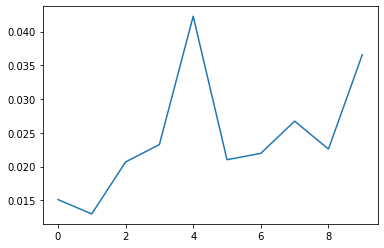

In [28]:
########################## loss plot #######################

import matplotlib.pyplot as plt
x = np.array(range(len(run_report['epoch'])))
y = np.array(run_report['eval_dev_loss'])
plt.plot(x,y)
plt.show()

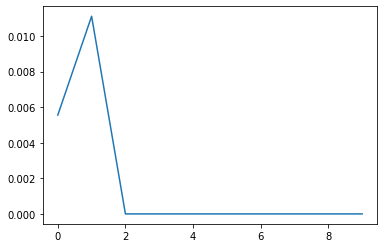

In [29]:
########################## accuracy plot #######################

import matplotlib.pyplot as plt
x = np.array(range(len(run_report['epoch'])))
y = np.array(run_report['eval_dev_acc'])
plt.plot(x,y)
plt.show()